In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import librosa
import json
import numpy as np
import scipy as sp
from scipy import signal
from scipy.io import wavfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Audio
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import os

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [3]:
mypath='.'
(_, _, filenames) = next(os.walk(mypath))
filenames = [file for file in filenames if file.split('.')[-1] == 'wav']

### Objective
The objective was to check the differece between clipped and non-clipped audio samples.

rPEF: 1.0
rFEV1: 284.06
rFVC: 23740.43
rPEF: 0.14
rFEV1: 20.93
rFVC: 1844.18


rRatio Diff: 0.061602487715729515


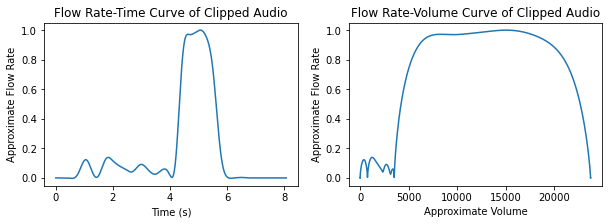

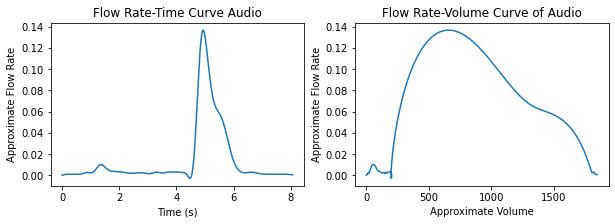

In [61]:
rRatio = []
for file in filenames:
    fig, ax = plt.subplots(1,2, figsize=(10,3));
    x, fs = librosa.load(file, sr=16000, dtype=np.float16)
    t = np.arange(0,len(x))/fs
    #ax[0].plot(t,x, alpha=0.5);
    cutoff_low = 6 # desired cutoff frequency of the filter, Hz
    cutoff_high = 4000
    order = 5

    #x_filt = butter_highpass_filter(x, cutoff, fs, order)
    x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
    #ax[1].plot(t,x_filt);
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    t = np.arange(0,len(envelope_hat_filt))/fs
    ax[0].plot(t,envelope_hat_filt);
    if file == "TestSample.FVC.NewFirmware.wav":
        ax[0].set_title("Flow Rate-Time Curve of Clipped Audio")
    else:
        ax[0].set_title("Flow Rate-Time Curve Audio")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Approximate Flow Rate")

    #at this point we have the 
    #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
    #envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
    rPEF = round(envelope_hat_filt.max(),2)
    print("rPEF: {}".format(rPEF))

    estdVolume = np.cumsum(envelope_hat_filt)
    #estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
    #FEV1 Estimate
    ax[1].plot(estdVolume,envelope_hat_filt)
    if file == "TestSample.FVC.NewFirmware.wav":
        ax[1].set_title("Flow Rate-Volume Curve of Clipped Audio")
    else:
        ax[1].set_title("Flow Rate-Volume Curve of Audio")
    ax[1].set_xlabel("Approximate Volume")
    ax[1].set_ylabel("Approximate Flow Rate")
    rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
    print("rFEV1: {}".format(rFEV1))
    #FVC Estimate
    rFVC = round(estdVolume[-1],2)
    print("rFVC: {}".format(rFVC))
    rRatio.append((rFEV1/rFVC)*100)
print("\n\nrRatio Diff: {}".format(abs(rRatio[0]-rRatio[1])))

### Objective 2: To sanity check 'wrong' looking samples.

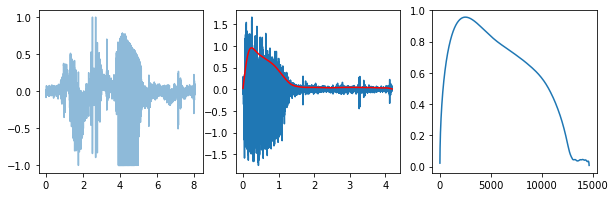

In [55]:
fig, ax = plt.subplots(1,3, figsize=(10,3));
x, fs = librosa.load("samples-for-test/Pulkit.FVC_N95.RCL.2dbikf27.wav", sr=16000, dtype=np.float16)
t = np.arange(0,len(x))/fs
ax[0].plot(t,x, alpha=0.5);
cutoff_low = 6 # desired cutoff frequency of the filter, Hz
cutoff_high = 3500
order = 5

#x_filt = butter_highpass_filter(x, cutoff, fs, order)
x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)

GOBACKSAMPLES = 4000 #THIS IS A TRICKY NUMBER TO SET TO GET THE CORRECT CURVE

#get peak of the signal and go for few samples; Thereafter, continue taking the signal for 4 seconds (64000 sampples)
x_filt = x_filt[np.argmax(x_filt)-GOBACKSAMPLES:np.argmax(x_filt)+64000]
t = np.arange(0,len(x_filt))/fs

ax[1].plot(t,x_filt);
x_filt_hilbert = signal.hilbert(x_filt)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 2.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
ax[1].plot(t, envelope_hat_filt, color='red')
t = np.arange(0,len(envelope_hat_filt))/fs
estdVolume = np.cumsum(envelope_hat_filt)

ax[2].plot(estdVolume,envelope_hat_filt)

#parameter extraction

#print()

### Old Break

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [17]:
fs = 16000

In [12]:
#code directly recorded from Edge Impulse
ei_data1Hz = pd.read_json("Sine1Hz.json", orient='records').T['values']['payload'][:60000]
ei_data1Hz_time = [n/fs for n in range(len(ei_data1Hz))]
ei_data7Hz = pd.read_json("Sine7Hz.json", orient='records').T['values']['payload'][:80000]
ei_data7Hz_time = [n/fs for n in range(len(ei_data7Hz))]
#code direcrly recorded from Arduino
ar_data1Hz = pd.read_csv("sine1hz.csv", names=['Data'])
ar_data1Hz_time = [n/fs for n in range(len(ar_data1Hz))]
ar_data7Hz = pd.read_csv("sine7hz.csv", names=['Data'])
ar_data7Hz_time = [n/fs for n in range(len(ar_data7Hz))]


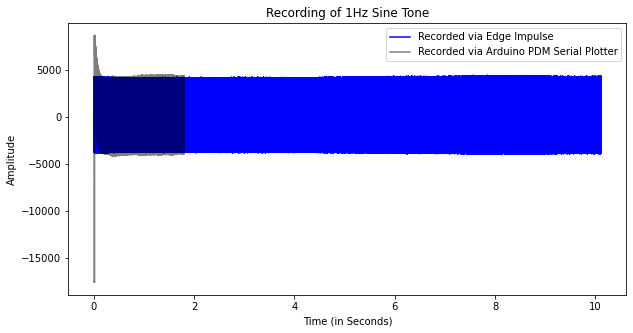

In [34]:
#changed gain to 127
fig, ax = plt.subplots(1,1, figsize=(10,5))
ar_1Hz127 = pd.read_csv("ar_1Hz127.csv", names=['Data'])
ar_1Hz127_time = [n/fs for n in range(len(ar_1Hz127))]
ei_1Hz127 = pd.read_json("ei_1Hz127.json", orient='records').T['values']['payload']
ei_1Hz127_time = [n/fs for n in range(len(ei_1Hz127))]

ax.plot(ei_1Hz127_time, ei_1Hz127, color='b')
ax.plot(ar_1Hz127_time, ar_1Hz127, color='k', alpha=0.5)
ax.set_title("Recording of 1Hz Sine Tone")
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Amplitude')
ax.legend(['Recorded via Edge Impulse', 'Recorded via Arduino PDM Serial Plotter'])

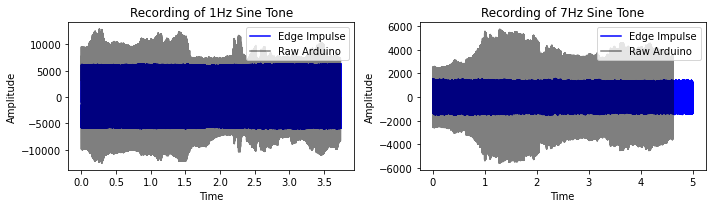

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(ei_data1Hz_time,ei_data1Hz,color='b')
ax[0].plot(ar_data1Hz_time, ar_data1Hz,color='k',alpha=0.5)
ax[0].legend(['Edge Impulse', 'Raw Arduino'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].set_title("Recording of 1Hz Sine Tone")

ax[1].plot(ei_data7Hz_time,ei_data7Hz,color='b')
ax[1].plot(ar_data7Hz_time, ar_data7Hz,color='k',alpha=0.5)
ax[1].legend(['Edge Impulse', 'Raw Arduino'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].set_title("Recording of 7Hz Sine Tone")



plt.tight_layout()

In [6]:
#play the data
Audio(ei_data1Hz, rate=fs)

In [10]:
#play the data
Audio(ar_data1Hz['Data'], rate=fs)

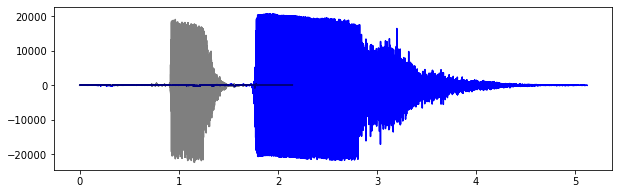

In [41]:
#ghust of wind test at gain of 127
#ghust of wind data
fig, ax = plt.subplots(1,1, figsize=(10,3))
ei_ghust = pd.read_json("ei_ghust_2.json", orient='records').T['values']['payload']
ei_ghust_time = [n/fs for n in range(len(ei_ghust))]
ar_ghust = pd.read_csv("ar_ghust127.csv", names=['Data'])
ar_ghust_time = [n/fs for n in range(len(ar_ghust))]

ax.plot(ei_ghust_time, ei_ghust, color='b');
ax.plot(ar_ghust_time, ar_ghust,color='k',alpha=0.5);